<h2 style="font-weight:700"> 예상 갱신보험료 자동화 </h2>

> <span style="font-weight:bold;">기존 작업방식</span>

① (1차담당자) SOL에서 예상갱신보험료 계산

② (1차담당자) 예상 갱신보험료 한글 파일에 보험료 기재

③ (2차담당자) 크로스

④ (공시담당) 취합 / 문서 편집 / 업로드

> 개선점

- SOL에서 계산한 보험료를 한글문서에 수기로 옮겨 적는 과정에서 휴먼 에러 발생

- ② 작업에 대신 Excel파일에 취합받아 일괄 pdf 변환

> <span style="font-weight:bold;">제안 작업방식</span>

① (1차담당자) SOL에서 예상갱신보험료 계산

② (1차담당자) 예상 갱신보험료 Excel 파일에 보험료 기재

③ (2차담당자) 크로스

④ (공시담당) 취합 / 문서 편집 / 업로드

<h4 style="font-weight:700;"> 예상갱신보험료 자동화 데모 </h4>

[현재 공시 양식]

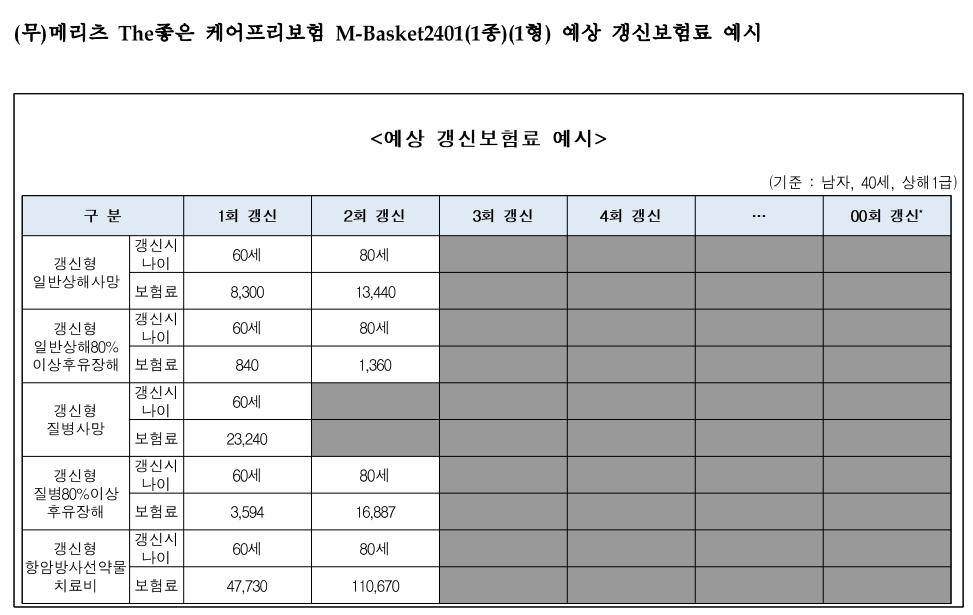

[Demo]

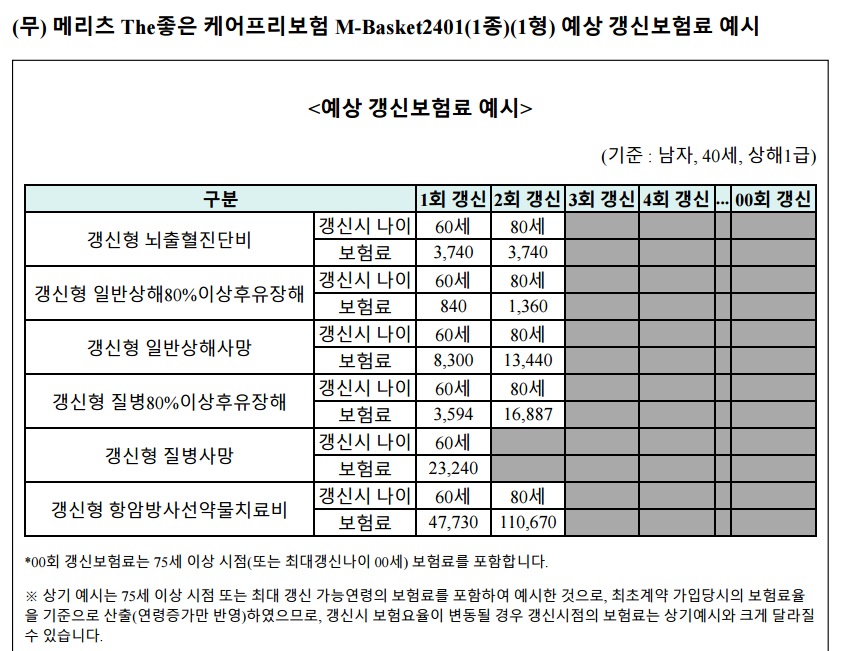

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from pyhtml2pdf import converter
import pandas as pd
import os

Util

In [3]:
class CoverageModel:
    """
    담보
        - coverage_name : 담보명
        - premimum_dict : 보험료 dictionary
    """
    def __init__(cls, coverage_name:str):
        cls.coverage_name = coverage_name
        cls.premimum_dict = {}

    def update(cls, age:int, premium:int):
        cls.premimum_dict[age] = premium
        
class ProductModel:
    """
    상품
        - product_name : 상품명
        - condition : 가입조건
        - coverage_dict : 담보 dictionary
    """
    def __init__(cls, product_name:str):
        cls.product_name = product_name
        cls.condition = None
        cls.coverage_dict = {}

    def update(cls, coverage_name:str, age:int, premium:int, condition:str):
        if (condition != None): cls.condition = condition
        coverage = cls.coverage_dict[coverage_name] if (coverage_name in cls.coverage_dict.keys()) \
            else CoverageModel(coverage_name=coverage_name)
        coverage.update(age=age, premium=premium)
        cls.coverage_dict[coverage_name] = coverage

class RenewalPremium:

    @property
    def html(cls)->str:
        return cls.__html_string()

    @property
    def product(cls)->str:
        return cls.__product
    
    @classmethod
    def set_product(cls, product:ProductModel):
        cls.__product = product

    @classmethod
    def save_html(cls, save_dir:str):
        """
        상품를 바탕으로 html 문서 생성
            - save_dir : html 파일 저장할 폴더경로
        """
        with open(f'{save_dir}/{cls.__product.product_name}.html', 'w', encoding='utf-8') as f:
            f.write(cls.__html_string())

    @staticmethod
    def html_to_pdf(html_dir:str, pdf_dir:str, product_name:str):
        """
        html을 pdf로 변환
        """
        html_path = os.path.abspath(os.path.join(html_dir, f'{product_name}.html'))
        pdf_path = os.path.abspath(os.path.join(pdf_dir, f'{product_name}.pdf'))
        converter.convert(f'file:///{html_path}', pdf_path)

    @classmethod
    def __html_string(cls)->str:
        """
        HTML 생성
        """
        rows = " ".join([cls.__html_for_coverage(c) for c in cls.__product.coverage_dict.values()])
        return f'''
            <!DOCTYPE html>
            <html lang="kr">
            <head>
                <meta charset="UTF-8"/>
                <meta name="viewport" content="width=device-width, initial-scale=1.0" />
                <title>예상갱신보험료</title>
            </head>
            <body>
                <h3>{cls.__product.product_name} 예상 갱신보험료 예시</h3>

                <div style="border: 1px solid; padding: 10px">
                <h3 style="text-align: center">&lt;예상 갱신보험료 예시&gt;</h3>
                <p style="text-align: right">(기준 : {cls.__product.condition})</p>
                <table style="width: 100%; border-collapse: collapse">
                    {cls.__html_for_header()}
                    <tbody>
                        {rows}
                    </tbody>
                </table>
                    {cls.__html_for_footer()}
                </div>
            </body>
            </html>
            '''
    
    @classmethod
    def __html_for_header(cls)->str:
        """
        테이블 헤더
        """
        return '''
                <thead style="background-color: #dcf2f1">
                    <th style="border: 1px solid #000000; text-align: center" colspan="2">구분</th>
                    <th style="border: 1px solid #000000; text-align: center">
                        1회 갱신
                    </th>
                    <th style="border: 1px solid #000000; text-align: center">
                        2회 갱신
                    </th>
                    <th style="border: 1px solid #000000; text-align: center">
                        3회 갱신
                    </th>
                    <th style="border: 1px solid #000000; text-align: center">
                        4회 갱신
                    </th>
                    <th style="border: 1px solid #000000; text-align: center">...</th>
                    <th style="border: 1px solid #000000; text-align: center">
                        00회 갱신
                    </th>
                </thead>
        '''
    
    @classmethod
    def __html_for_coverage(cls, coverage:CoverageModel)->str:
        """
        담보 1개의 연령별 예상 갱신보험료
        """
        items = list(coverage.premimum_dict.items())
        items.sort(key=lambda x:x[0])                                       # 연령순으로 정렬
        items = [(f'{i[0]}세',  '{:,}'.format(i[1])) for i in items]        # 연령에 "세" 붙이기
        items = items + [('', '') for _ in range(6-len(items))]             # 보험료가 없는 연령에는 빈 문자열

        return f'''
            <tr>
                <td rowspan="2" style="border: 1px solid #000000; text-align: center;">{coverage.coverage_name}</td>
                <td style="border: 1px solid #000000; text-align: center;">갱신시 나이</td>                
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[0][0]=="" else ""}">{items[0][0]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[1][0]=="" else ""}">{items[1][0]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[2][0]=="" else ""}">{items[2][0]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[3][0]=="" else ""}">{items[3][0]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[4][0]=="" else ""}">{items[4][0]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[5][0]=="" else ""}">{items[5][0]}</td>
            </tr>
            <tr>
                <td style="border: 1px solid #000000; text-align: center;">보험료</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[0][1]=="" else ""}">{items[0][1]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[1][1]=="" else ""}">{items[1][1]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[2][1]=="" else ""}">{items[2][1]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[3][1]=="" else ""}">{items[3][1]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[4][1]=="" else ""}">{items[4][1]}</td>
                <td style="border: 1px solid #000000; text-align: center;{"background-color: darkgray;" if items[5][1]=="" else ""}">{items[5][1]}</td>   
            </tr>
        '''
    
    @classmethod
    def __html_for_footer(cls)->str:
        """
        안내문구
        """
        return '''
            <p style="font-size:0.8rem;">*00회 갱신보험료는 75세 이상 시점(또는 최대갱신나이 00세) 보험료를 포함합니다.</p>
            <p style="font-size:0.8rem;">※ 상기 예시는 75세 이상 시점 또는 최대 갱신 가능연령의 보험료를 포함하여 예시한 것으로, 최초계약 가입당시의 보험료율을 기준으로 산출(연령증가만 반영)하였으므로, 갱신시 보험요율이 변동될 경우 갱신시점의 보험료는 상기예시와 크게 달라질 수 있습니다.</p>
        '''

In [4]:
RENEWAL_PREMIUM_LIST_PATH = './input/renewal_premium.txt'
TEMP_DIR = './output/temp'
OUTPUT_DIR = './output'

In [5]:
rpa = RenewalPremium()      # RPA 인스턴스
os.makedirs(os.path.abspath(TEMP_DIR), exist_ok=True)
os.makedirs(os.path.abspath(OUTPUT_DIR), exist_ok=True)

예상 갱신보험료 INPUT

    상품명/급여명/연령/보험료/기준

In [6]:
df_renewal = pd.read_csv(RENEWAL_PREMIUM_LIST_PATH, sep='\t')
print(f"{df_renewal.shape[0]}개의 행을 불러옴")
df_renewal.head()

22개의 행을 불러옴


,상품명,급여명,연령,보험료,기준
0,(무) 메리츠 The좋은 케어프리보험 M-Basket2401(1종)(1형),갱신형 뇌출혈진단비,60,3740,"남자, 40세, 상해1급"
1,(무) 메리츠 The좋은 케어프리보험 M-Basket2401(1종)(1형),갱신형 일반상해80%이상후유장해,60,840,"남자, 40세, 상해1급"
2,(무) 메리츠 The좋은 케어프리보험 M-Basket2401(1종)(1형),갱신형 일반상해사망,60,8300,"남자, 40세, 상해1급"
3,(무) 메리츠 The좋은 케어프리보험 M-Basket2401(1종)(1형),갱신형 질병80%이상후유장해,60,3594,"남자, 40세, 상해1급"
4,(무) 메리츠 The좋은 케어프리보험 M-Basket2401(1종)(1형),갱신형 질병사망,60,23240,"남자, 40세, 상해1급"


작업

In [7]:
for (product_name, df) in df_renewal.groupby(['상품명']):

    product_name = product_name[0]

    try:                                    
    
        # 상품정보 세팅하기
        product = ProductModel(product_name=product_name)
        for row in df.values:
            _, coverage_name, age, premium, condition = row
            product.update(
                coverage_name=coverage_name,
                age=age,
                premium=premium,
                condition=condition
            )
        rpa.set_product(product=product)
 
        # HTML 문서 생성
        rpa.save_html(TEMP_DIR)

        # HTML → PDF로 변환
        rpa.html_to_pdf(html_dir=TEMP_DIR, pdf_dir=OUTPUT_DIR, product_name=product_name)

    # 오류 처리
    except:
        print(f"[ERROR] {product_name} 작업 中 오류가 발생했습니다")